<a href="https://colab.research.google.com/github/ANILESLAVATH12/customer-churn/blob/main/Predict_Customer_Churn_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3: SetUp: Importing the Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from sklearn import model_selection, metrics  #to include metrics for evaluation # this used to be cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
# Quiet warnings since this is a demo (it quiets future and deprecation warnings).
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 4: Access Data and Clean It Up

We're using the IBM Telco sample dataset for this case study. It provides some of the datapoints from our wish list but not all.

I staged the IBM sample dataset on my own S3 bucket on AWS and I'm accessing it from there:

In [7]:
!wget https://s3.amazonaws.com/ibm-sample-cust-churn-data/WA_Fn-UseC_-Telco-Customer-Churn.csv

--2025-03-12 03:43:34--  https://s3.amazonaws.com/ibm-sample-cust-churn-data/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.224.216, 52.216.222.32, 54.231.140.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.224.216|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-03-12 03:43:35 ERROR 404: Not Found.



In [8]:
ls -l

total 4
drwxr-xr-x 1 root root 4096 Mar 10 13:30 sample_data/


In [10]:
# Read the data and view the top portion to see what we are dealing with.
data=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [11]:
# See if the data is usable.
data.info()

NameError: name 'data' is not defined

In [12]:
# Analyze if there is non-numeric data in the 'TotalCharges' column since it's showing as an object instead of float64.
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors = 'coerce')
data.loc[data['TotalCharges'].isna()==True]

NameError: name 'data' is not defined

In [ ]:
# Above we see that the blank "TotalCharges" happen when customers have 0 months tenure so we will change those values to $0.
data[data['TotalCharges'].isna()==True] = 0
data['OnlineBackup'].unique()

In [ ]:
# See how many rows and columns.
data.shape

More data cleanup: next we’ll convert the categorical values into numeric values.

In [ ]:
data['gender'].replace(['Male','Female'],[0,1],inplace=True)
data['Partner'].replace(['Yes','No'],[1,0],inplace=True)
data['Dependents'].replace(['Yes','No'],[1,0],inplace=True)
data['PhoneService'].replace(['Yes','No'],[1,0],inplace=True)
data['MultipleLines'].replace(['No phone service','No', 'Yes'],[0,0,1],inplace=True)
data['InternetService'].replace(['No','DSL','Fiber optic'],[0,1,2],inplace=True)
data['OnlineSecurity'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['OnlineBackup'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['DeviceProtection'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['TechSupport'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['StreamingTV'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['StreamingMovies'].replace(['No','Yes','No internet service'],[0,1,0],inplace=True)
data['Contract'].replace(['Month-to-month', 'One year', 'Two year'],[0,1,2],inplace=True)
data['PaperlessBilling'].replace(['Yes','No'],[1,0],inplace=True)
data['PaymentMethod'].replace(['Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)'],[0,1,2,3],inplace=True)
data['Churn'].replace(['Yes','No'],[1,0],inplace=True)

data.info()

Let's look at relationships between customer data and churn using correlation.

In [ ]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Our goal is to avoid multicollinearity by dropping features that are closely correlated with each other. For example here it is TotalCharges and MonthlyCharges. So we will drop TotalCharges.

In [ ]:
	data.pop('TotalCharges')

In [ ]:
# Run info again to make sure TotalCharges has been dropped (popped off).
data.info()

Rerun corr chart after cleanup. TotalCharges should not appear in the corr chart.

In [ ]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## 5: Explore The Data

In [ ]:
# Explore how many churn data points we have.
print(len(data['Churn']))

7043


In [ ]:
# Explore how many customers in this dataset have churned. Is this dataset 50% as the team suggests is the overall customer churn rate?
data['Churn'].value_counts()
# We see this dataset actually has less than the overall 50% churn rate of the entire company reported data (it's actually 26.54% that have churned.

0    5174
1    1869
Name: Churn, dtype: int64

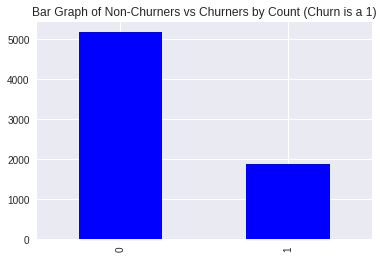

In [ ]:
# This creates a bar graph of churn (Yes vs. No) so we can check how the data is balanced.
data['Churn'].value_counts().plot(kind = 'bar', title = 'Bar Graph of Non-Churners vs Churners by Count (Churn is a 1)', color = 'blue', align = 'center')
plt.show()
# The dataset does not have a huge imbalance which is good news! But also we clearly see it does not have the 50% as we would have thought.

Explore some contingencies on how some features relate to churn.

In [ ]:
# Creates initial contingency table between Churn and gender. Male is 0, Female is 1.
gender_churn_contingency = pd.crosstab(data["gender"], data["Churn"])
display(gender_churn_contingency)
# Male and females churn at about the same rate, so not much to see here. Let's keep moving.

Churn,0,1
gender,,
0,2630,930
1,2544,939


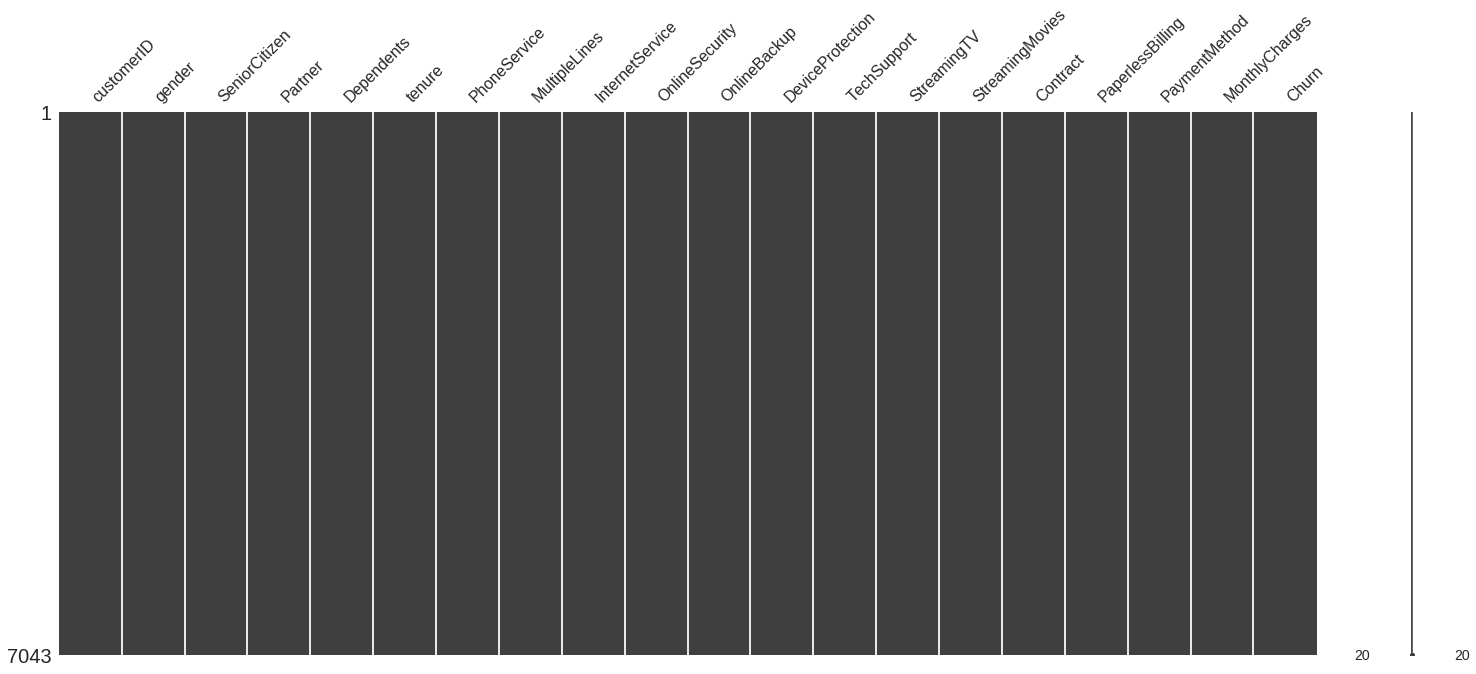

In [ ]:
# Check the data health. The sections should all be completely black indicating the data is complete.
ms.matrix(data)
# It looks good.

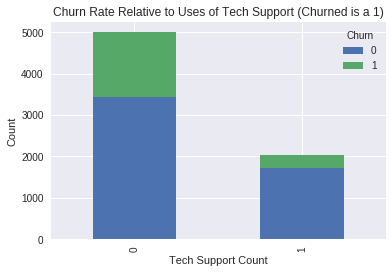

In [ ]:
# Explore the relationship between instances of Tech Support and Churn.
# Stacked Bar of Tech Support and Churn.
tech_support_churn = pd.crosstab(data['TechSupport'], data['Churn'])
tech_support_churn.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Tech Support Count')
plt.title('Churn Rate Relative to Uses of Tech Support (Churned is a 1)')
plt.show()
# We can see that non-churners use tech support more often than customers that end up churning.
# So let's explore some ways to get people to use Tech Support more often so they cancel (churn) less. You can see notes for this at the bottom.
# Also, tech support in this data is just a Y/N. It would be useful in future to include how many tech support calls by customer so we could analyze how the number of tech support calls relates to churn.

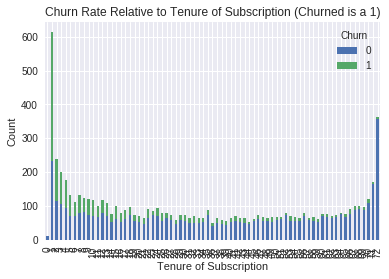

In [ ]:
# Churn rate relative to tenure.
# Stacked bar of tenure and churn.
tenure_churn = pd.crosstab(data['tenure'], data['Churn'])
tenure_churn.plot(kind = 'bar', stacked = True)
plt.ylabel('Count')
plt.xlabel('Tenure of Subscription')
plt.title('Churn Rate Relative to Tenure of Subscription (Churned is a 1)')
plt.show()
# We can clearly see the longer a customer stays as a subscriber, the less they are likely to churn!

In [ ]:
# Distribution of features.
features = ['gender', 'SeniorCitizen','Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges']
data[features].describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.494534,0.162147,0.481755,0.298026,32.371149,0.901888,0.421269,1.222206,0.286100,0.344314,0.343320,0.289649,0.383785,0.387761,0.687491,0.591793,1.313503,64.697004
std,0.500006,0.368612,0.499702,0.457424,24.559481,0.297487,0.493798,0.779535,0.451969,0.475178,0.474851,0.453632,0.486341,0.487274,0.832727,0.491537,1.149799,30.171186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.450000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,70.350000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.850000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.750000


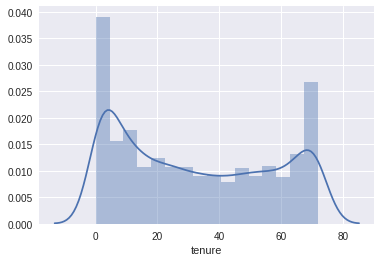

In [ ]:
# Plot the distribution of observations for tenure.
sns.distplot(data['tenure']);
# It shows the max tenure is 70. This must be when the data history ends. We'll account for this in our analysis.

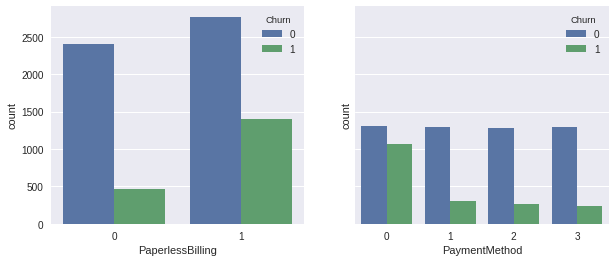

In [ ]:
# Does how a customer pays have to do with their churn?
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.countplot(x='PaperlessBilling', hue='Churn',
              data=data, ax=axes[0]);
sns.countplot(x='PaymentMethod', hue='Churn',
              data=data, ax=axes[1]);
# We can see that customers that use paperless billing are much more likely to churn (0 = don't have paperless billing). That seems backwards I would go check that data with the team.
# We can see that customers that have the 0 payment method (electronic check) are much more likely to churn. Let's discourage that option.

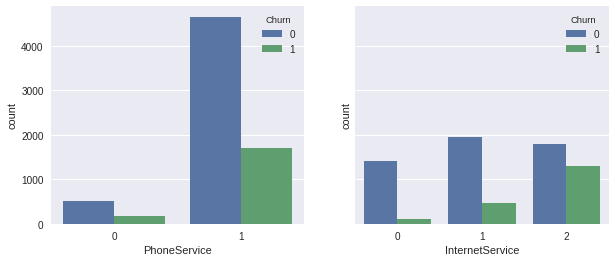

In [ ]:
# See if the other products they have from this company has to do with their churn.
_, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.countplot(x='PhoneService', hue='Churn',
              data=data, ax=axes[0]);
sns.countplot(x='InternetService', hue='Churn',
              data=data, ax=axes[1]);
# If they don't have Phone Service, they are more likely to churn.
# If they don't have Internet Service, they are more likely to churn. Those customers with the highest Internet Service are least likely to churn.
# Conclusion: This makes sense. Customers with other products from the company, and premium products, churn less.
# Offer customers these additional products, perhaps even at a deep discount, so they take them and are less likely to churn.

## 6:  Prepare the Data

In [ ]:
# Splitting the data for testing and training.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Churn',axis=1),
                                                    data['Churn'], test_size=0.30,
                                                    random_state=101)

In [ ]:
train=pd.concat([X_train,y_train],axis=1)

In [ ]:
# Function to estimate the best value of n_estimators and fit the model with the given data.

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        #to get the parameters of xgboost
        xgb_param = alg.get_xgb_params()

        #to convert into a datastructure internally used by xgboost for training efficiency
        # and speed
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)

        #xgb.cv is used to find the number of estimators required for the parameters
        # which are set
        cvresult = xgb.cv(xgb_param, xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                        metrics='auc', early_stopping_rounds=early_stopping_rounds)

        #setting the n_estimators parameter using set_params
        alg.set_params(n_estimators=cvresult.shape[0])

        print(alg.get_xgb_params())

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Churn'],eval_metric='auc')

    return alg

In [ ]:
# Function to get the accuracy of the model on the test data given the features considered.

In [ ]:
def get_accuracy(alg,predictors):
    dtrain_predictions = alg.predict(X_test[predictors])
    dtrain_predprob = alg.predict_proba(X_test[predictors])[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test.values,
                                                      dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test.values,
                                                           dtrain_predprob))

In [ ]:
# Function to get the feature importances based on the model fit.

In [ ]:
def get_feature_importances(alg):
    #to get the feature importances based on xgboost we use fscore
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    print(feat_imp)

    #this shows the feature importances on a bar chart
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
target = 'Churn'
IDcol = 'customerID'

## 7: Model Selection, Predictions, and Metrics

In [ ]:
# To return the XGBClassifier object based on the values of the features.

In [ ]:
!pip install xgboost
# XGBoost converts weak learners to strong learners through an ensemble method.
# Unlike bagging, in the classical boosting the subset creation is not random and depends upon the performance of the previous models.

In [ ]:
def XgbClass(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,
             gamma=0,subsample=0.8,colsample_bytree=0.8):
    xgb1 = XGBClassifier(learning_rate=learning_rate,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         min_child_weight=min_child_weight,
                         gamma=gamma,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree)
    return xgb1

In [ ]:
# Function to return the list of predictors.

In [ ]:
# These are the initial parameters before tuning.
def drop_features(l):
    return [x for x in train.columns if x not in l]

### First Prediction: Use of initial parameters and without feature engineering

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
predictors = drop_features([target, IDcol])
xgb1=XgbClass()
first_model=modelfit(xgb1, train, predictors)
xgb1.fit(train[predictors],train['Churn'])

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 33, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 0.8}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=33,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [ ]:
get_accuracy(first_model,predictors)


Model Report
Accuracy : 0.8022
AUC Score (Train): 0.849018


**Accuracy** is the proportion of true positives and negatives in the whole data set. It determines if a value is accurate compare it to the accepted value; the nearness of a calculation to the true value.

**AUC** (area under the ROC receiver operating characteristic curve) measures how true positive rate (recall) and false positive rate trade off, so in that sense it is already measuring something else. More importantly, AUC is not a function of threshold. It is an evaluation of the classifier as threshold varies over all possible values. It is in a sense a broader metric, testing the quality of the internal value that the classifier generates and then compares to a threshold.

**Accuracy vs AUC**: The accuracy depends on the threshold chosen, whereas the AUC considers all possible thresholds. Because of this it is often preferred as it provides a “broader” view of the performance of the classifier, but they still measure different things and as such using one or the other is problem-dependent.

MonthlyCharges      270
tenure              195
PaymentMethod        58
Contract             57
InternetService      42
OnlineBackup         39
StreamingTV          26
PaperlessBilling     26
OnlineSecurity       25
SeniorCitizen        24
TechSupport          23
Partner              20
PhoneService         18
MultipleLines        18
StreamingMovies      16
gender               16
Dependents           16
DeviceProtection     12
dtype: int64


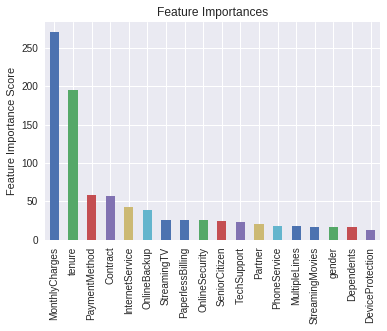

In [ ]:
get_feature_importances(first_model)

### Second Prediction: Using intial Parameters and removing features of least importances

In [ ]:
# Model after removing the features of least importance.

In [ ]:
dropl=['DeviceProtection','Dependents','Dependents','gender','StreamingMovies','MultipleLines']

In [ ]:
dropl_first=dropl+[target,IDcol]

In [ ]:
# These are the initial parameters before tuning.
predictors = drop_features(dropl_first)
xgb1 = XgbClass()
second_model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 35, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 0.8}


In [ ]:
get_accuracy(second_model,predictors)


Model Report
Accuracy : 0.8069
AUC Score (Train): 0.847366


MonthlyCharges      289
tenure              190
PaymentMethod        87
Contract             63
InternetService      57
SeniorCitizen        38
PaperlessBilling     35
StreamingTV          30
OnlineSecurity       29
TechSupport          28
OnlineBackup         28
PhoneService         26
Partner              26
dtype: int64


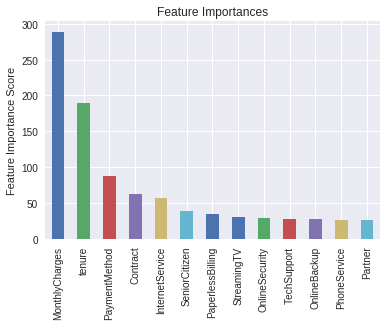

In [ ]:
get_feature_importances(second_model)

### Third Prediction: Again removing the features of least importance

In [ ]:
dropl1=dropl+['Partner','PhoneService','OnlineBackup','TechSupport','OnlineSecurity']
dropl_second=dropl_first+['Partner','PhoneService','OnlineBackup','TechSupport','OnlineSecurity']

In [ ]:
predictors=drop_features(dropl_second)

In [ ]:
xgb1=XgbClass()
third_model=modelfit(xgb1,train,predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 50, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 0.8}


In [ ]:
get_accuracy(third_model,predictors)


Model Report
Accuracy : 0.7984
AUC Score (Train): 0.843116


## 8: Predict on New Cases

In [ ]:
# Function stores the result in required csv file and features. I removed this section for now as the csv files are not yet saving correctly. See prototype version of notebook for details.

## 9: Tuning

In [ ]:
# Tune max_depth and min_child_weight.

In [ ]:
predictors = drop_features(dropl_first)
predictors

['SeniorCitizen',
 'Partner',
 'tenure',
 'PhoneService',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'TechSupport',
 'StreamingTV',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges']

In [ ]:
param_test1 = {
 'max_depth':list(range(5,10,1)),
 'min_child_weight':list(range(5,10,1))
}
gsearch1 = GridSearchCV(estimator=XgbClass(n_estimators=48),param_grid =param_test1,
                        scoring='roc_auc',n_jobs=-1,iid=False, cv=5, verbose=3)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   21.5s finished


({'mean_fit_time': array([0.20724802, 0.20932374, 0.20880656, 0.20871305, 0.21010675,
         0.24907684, 0.25009632, 0.24860916, 0.24591808, 0.24454684,
         0.28334703, 0.28474541, 0.28169541, 0.28036094, 0.27825117,
         0.31879997, 0.31600304, 0.31035895, 0.30742917, 0.3038981 ,
         0.34530797, 0.33879218, 0.3390099 , 0.32813511, 0.31488495]),
  'mean_score_time': array([0.00653849, 0.00614457, 0.00613132, 0.00614538, 0.00614262,
         0.00677257, 0.00668726, 0.00675406, 0.00672469, 0.00657935,
         0.00738587, 0.00716372, 0.0071681 , 0.00734129, 0.006917  ,
         0.00756946, 0.00752988, 0.00749302, 0.00734549, 0.00724516,
         0.00789227, 0.00772715, 0.00758004, 0.00755405, 0.00721326]),
  'mean_test_score': array([0.84350596, 0.84539506, 0.84513634, 0.84523376, 0.84500423,
         0.84303827, 0.84317968, 0.84321582, 0.84356301, 0.84444605,
         0.84189866, 0.84086484, 0.84214285, 0.84234019, 0.84326609,
         0.83943562, 0.84043105, 0.84044683,

In [ ]:
# If the best parameters are edge values then we do
# GridSearchCV by taking one less and one value more than the best parameters.

In [ ]:
param_test2 = {
 'max_depth':[6,7,8,9],
 'min_child_weight':[2,3,4,5]
}
gsearch2 = GridSearchCV(estimator=XgbClass(n_estimators=48),param_grid =param_test2,scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.25651345, 0.24808664, 0.25345564, 0.24944706, 0.28951616,
         0.28822298, 0.28571844, 0.28517208, 0.32676215, 0.32411208,
         0.32022843, 0.31513767, 0.36551666, 0.35565701, 0.34868417,
         0.3419539 ]),
  'mean_score_time': array([0.00697908, 0.00703349, 0.00803852, 0.00803237, 0.00733232,
         0.00735245, 0.00715566, 0.00723968, 0.00774646, 0.00772562,
         0.00789828, 0.00892334, 0.00814891, 0.00829682, 0.0079906 ,
         0.00785379]),
  'mean_test_score': array([0.84042715, 0.84189787, 0.8428498 , 0.84303827, 0.8398022 ,
         0.83976764, 0.84035653, 0.84189866, 0.83624953, 0.8369503 ,
         0.83858558, 0.83943562, 0.83412339, 0.83550116, 0.83753711,
         0.83793307]),
  'mean_train_score': array([0.91253411, 0.90805523, 0.90370692, 0.90002083, 0.93031609,
         0.92219569, 0.9160066 , 0.91041047, 0.94335466, 0.93313675,
         0.92526439, 0.91758409, 0.95263699, 0.94049106, 0.93067881,
         0.92202018]),
  'pa

In [ ]:
xgb1 = XgbClass(max_depth=8,min_child_weight=4)
model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 4, 'missing': None, 'n_estimators': 20, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 0.8}


In [ ]:
get_accuracy(model,predictors)


Model Report
Accuracy : 0.7979
AUC Score (Train): 0.843505


In [ ]:
# To tune gamma.

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,8)]
}
gsearch3=GridSearchCV(estimator=XgbClass(n_estimators=48,max_depth=7,min_child_weight=5),
                      param_grid =param_test3,scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.28967605, 0.28326716, 0.28377404, 0.28291426, 0.28900743,
         0.29015837, 0.29366841, 0.28920174]),
  'mean_score_time': array([0.00724435, 0.00734229, 0.00721374, 0.0086863 , 0.00774436,
         0.007374  , 0.00738888, 0.00745301]),
  'mean_test_score': array([0.84189866, 0.84089109, 0.84198526, 0.84263784, 0.8409183 ,
         0.8416148 , 0.84014798, 0.84140207]),
  'mean_train_score': array([0.91041047, 0.91040467, 0.91002945, 0.90957837, 0.90951727,
         0.90899937, 0.90847181, 0.9084777 ]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4},
   {'gamma': 0.5},
   {'gamma': 0.6},
   {'gamma': 0.7}],
  'rank_test_score': array([3, 7, 2, 1, 6, 4, 8, 5], dtype=int32),
  'split0_test_score':

In [ ]:
xgb1 = XgbClass(max_depth=7,min_child_weight=5,gamma=0)
model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 5, 'missing': None, 'n_estimators': 20, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 0.8}


In [ ]:
get_accuracy(model,predictors)


Model Report
Accuracy : 0.8027
AUC Score (Train): 0.844282


In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4=GridSearchCV(estimator=XgbClass(n_estimators=48,max_depth=7,
                                         min_child_weight=5,gamma=0),
                      param_grid =param_test4,scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.24761925, 0.24028883, 0.23841305, 0.23658376, 0.27860475,
         0.27579222, 0.27358937, 0.25988464, 0.28870115, 0.28766732,
         0.28121572, 0.27407904, 0.304284  , 0.30221763, 0.29781356,
         0.28894463]),
  'mean_score_time': array([0.00745382, 0.00756383, 0.00910616, 0.00766773, 0.00748549,
         0.00750766, 0.00747414, 0.00724821, 0.00714731, 0.00728402,
         0.00721726, 0.00721107, 0.00716071, 0.00730948, 0.00833058,
         0.00849657]),
  'mean_test_score': array([0.84051166, 0.84041769, 0.84022394, 0.84168989, 0.83987525,
         0.84008881, 0.84050073, 0.84057328, 0.84029717, 0.83995671,
         0.84189866, 0.83927434, 0.83927259, 0.83936597, 0.84106022,
         0.83889594]),
  'mean_train_score': array([0.89651826, 0.90120841, 0.90492691, 0.90857003, 0.89975845,
         0.90490393, 0.90868614, 0.91178254, 0.90200789, 0.90601781,
         0.91041047, 0.91265981, 0.90269874, 0.90713974, 0.91118315,
         0.91401333]),
  'pa

In [ ]:
xgb1 = XgbClass(max_depth=8,min_child_weight=4,gamma=0.4,subsample=0.8,colsample_bytree=0.6)
model=modelfit(xgb1, train, predictors)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.6, 'gamma': 0.4, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 4, 'missing': None, 'n_estimators': 18, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 0.8}


In [ ]:
get_accuracy(model,predictors)


Model Report
Accuracy : 0.7979
AUC Score (Train): 0.843383


In [ ]:
#dropl1=dropl+['Partner','PhoneService','OnlineBackup','TechSupport','OnlineSecurity']
# RunTestAndSaveResults(dropl,'final_result.csv',model)
#FixMeLater the final_result file is not printing to csv

In [ ]:
ls -l

## 10: Next Steps
* Run some actual data from your company. For case study purposes, let's keep going with dummy data ...
* After some initial analysis, cleaning, and tuning we're consistently getting an accuracy of 80% and AUC ~84%. Feature engineering and tuning did not improve (in some cases made worse, seems to be overfitting).
* This meets our prediction success threshold of 80%.
* Share findings with team.
* Discuss some possible next steps:
    * Get more data. This is only ~7k records and much different than the stated overall 50%.
    * Get more detailed data on features that are showing to be relatively MORE predictive:
      * MonthlyCharges
      * Tenure
      * PaymentMethod
      * Plan Types
      
  * **Get more detailed data on features that are showing to be relatively LESS predictive but our analysis show with more details they could be really useful**
      * Tech support: how many calls to tech support lifetime and in past month since churning, instead of just a contact tech support: Y / N.
  * **Get additional data on features we think may be very predictive but we don't have here yet**
    * Time to first success point
    * Other data specific to the business
    * Etc.
    
 ## Help Transform Customer Experience
  * Iterate products to transform customer experiences:
    * Personalized features (i.e if low NPS go to different flow)
    * Data predictions (i.e. predict churn from TechSupport interaction and alert the customer support team to intervene, and automatically have the technology prompt the user for answering their questions),
    * Propensity modeling (i.e set scorecards for customer predicted churn based on numerous factors. flag those users when they go 'red" for action with marketing and customer case outreach).
  
  **Activity loop:**
  * Iterate
  * Communicate
  * Put into production
  * Scale
  * Assess
  * Repeat
  
  Questions?
  Michelle Bonat
  michelle.bonat@gmail.com
  [michellebonat.com](http://michellebonat.com)

## 11: Appendix

## The initial data showed that more tech support interactions reduced customer churn. Here are some ways to put that information into action:
To get customers interacting with tech support instead of cancelling:

1) Include this NPS data in the dataset for analysis, it is from the questionnaire in QuickBooks.

2) Make sure screens/flow to include links to Support during the Cancel process.

3) Offer users a way to get help even live chat right there instead of just a cancel option.

4) There could also be a 'Resolve Your Issue' link right next to the cancel option.